In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [38]:
def preprocess_data(data):
    """
    Preprocess the data for multi-class classification.
    
    Parameters:
    - data: pandas.DataFrame containing the following columns:
        - category: emotional category of the reel
        - percentage_watched: percentage of reel watched
        - eeg_theta_beta_ratio: EEG theta/beta ratio
        - eeg_alpha_asymmetry: EEG frontal alpha asymmetry
        - eeg_gamma_power: EEG gamma band power

    Returns:
    - X_train, X_test, y_train, y_test: Preprocessed training and testing data
    - feature_names: Names of features for importance plotting
    """
    # Define features and target
    y = data['Label']
    X = data.drop(columns=['time', 'url', 'Label'])
    
    # Store feature names for later use
    feature_names = X.columns.tolist()

    # # Scale numerical features
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)

    # Perform train/test split (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, feature_names

def train_multi_class_model(X_train, y_train):
    """
    Train a multi-class classification model using Random Forest.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels

    Returns:
    - model: Trained Random Forest model
    - cross_val_scores: Cross-validation scores
    """
    # Initialize the Random Forest classifier
    model = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=42)


    # Train the model on the full training set
    model.fit(X_train, y_train)

    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test set.
    
    Parameters:
    - model: Trained Random Forest model
    - X_test: Test features
    - y_test: Test labels

    Returns:
    - report: Classification report
    - accuracy: Accuracy score
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # generate values for ROC curve and after predicting on y_pred
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=np.unique(y_test), output_dict=True)
  

    return report, accuracy

def plot_feature_importance(model, feature_names):
    """
    Plot feature importance for the trained Random Forest model.
    
    Parameters:
    - model: Trained Random Forest model
    - feature_names: List of feature names
    """
    # Extract feature importance
    importance = model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def create_sample_data(n_samples=500):
    """
    Create sample data for demonstration purposes.
    
    Parameters:
    - n_samples: Number of samples to generate
    
    Returns:
    - data: pandas DataFrame with sample data
    """
    np.random.seed(42)
    
    # Define categories
    categories = ['Negative News', 'Inspirational', 'Humor', 'Aspirational Lifestyle', 'Educational']
    
    # Generate random data
    data = pd.DataFrame({
        'reel_id': [f'reel_{i}' for i in range(n_samples)],
        'category': np.random.choice(categories, n_samples),
        'percentage_watched': np.random.uniform(0, 1, n_samples),
        'eeg_theta_beta_ratio': np.random.normal(1.2, 0.3, n_samples),
        'eeg_alpha_asymmetry': np.random.normal(0.1, 0.05, n_samples),
        'eeg_gamma_power': np.random.normal(0.5, 0.2, n_samples),
        'eeg_frontal_beta': np.random.normal(0.8, 0.3, n_samples),
        'eeg_occipital_alpha': np.random.normal(1.5, 0.4, n_samples)
    })
    
    # Add some correlation between features and categories
    for i, category in enumerate(categories):
        mask = data['category'] == category
        
        # Adjust features based on category
        if category == 'Negative News':
            data.loc[mask, 'eeg_theta_beta_ratio'] += 0.3
            data.loc[mask, 'eeg_gamma_power'] += 0.2
        elif category == 'Inspirational':
            data.loc[mask, 'eeg_alpha_asymmetry'] += 0.05
            data.loc[mask, 'eeg_occipital_alpha'] += 0.4
        elif category == 'Humor':
            data.loc[mask, 'percentage_watched'] += 0.2
            data.loc[mask, 'eeg_gamma_power'] += 0.3
        elif category == 'Aspirational Lifestyle':
            data.loc[mask, 'eeg_frontal_beta'] += 0.2
            data.loc[mask, 'percentage_watched'] -= 0.1
        elif category == 'Educational':
            data.loc[mask, 'eeg_theta_beta_ratio'] -= 0.2
            data.loc[mask, 'eeg_occipital_alpha'] += 0.2
    
    # Ensure percentage_watched is between 0 and 1
    data['percentage_watched'] = data['percentage_watched'].clip(0, 1)
    
    return data

In [33]:
data = pd.read_csv('reel_eeg_data.csv')
del data["label"]
new_label = ["Neutral" if label == "Interested" else label for label in data["Label"]]
new_label = ["Excited" if label == "Funny" else label for label in new_label]
data["Label"] = new_label
data

,time,url,time spent on this reel,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4,Label
0,17:10:21,https://www.instagram.com/reels/DHl1NfMsE-a/,41.0,4230.400374,4243.084936,4082.138078,4220.904204,Neutral
1,17:11:02,https://www.instagram.com/reels/DHq67Pfvpkm/,9.0,4227.094920,4246.773727,4082.154553,4220.463637,Sad
2,17:11:11,https://www.instagram.com/reels/DCZgltAh7mI/,6.0,4211.022630,4223.947483,4063.663529,4206.160854,Excited
3,17:11:17,https://www.instagram.com/reels/DG-5yNEJjJX/,25.0,4234.912460,4246.478404,4086.333774,4225.174516,Excited
4,17:11:42,https://www.instagram.com/reels/DFbAj8FyW06/,18.0,4228.611778,4244.216854,4081.364519,4220.788039,Excited
...,...,...,...,...,...,...,...,...
97,17:57:25,https://www.instagram.com/reels/DHrh66Dui-7/,4.0,4211.387717,4210.235124,4065.204580,4206.110530,Neutral
98,17:57:29,https://www.instagram.com/reels/DHt0rz2BFt7/,7.0,4238.923859,4236.365614,4090.300773,4227.251320,Excited
99,17:57:36,https://www.instagram.com/reels/DHmbQG1saBl/,15.0,4235.776982,4233.846416,4086.978430,4223.465876,Excited
100,17:57:51,https://www.instagram.com/reels/DHlVfGjOEGJ/,3.0,4225.301470,4234.955928,4087.084669,4220.840672,Excited


In [34]:
data["Label"].value_counts()

Label
Neutral    56
Excited    29
Sad        17
Name: count, dtype: int64


Test Set Evaluation:
Accuracy: 0.5238

Classification Report:
{'Excited': {'precision': 0.6666666666666666, 'recall': 0.25, 'f1-score': 0.36363636363636365, 'support': 8.0}, 'Neutral': {'precision': 0.5294117647058824, 'recall': 0.9, 'f1-score': 0.6666666666666666, 'support': 10.0}, 'Sad': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, 'accuracy': 0.5238095238095238, 'macro avg': {'precision': 0.3986928104575163, 'recall': 0.3833333333333333, 'f1-score': 0.3434343434343434, 'support': 21.0}, 'weighted avg': {'precision': 0.5060690943043884, 'recall': 0.5238095238095238, 'f1-score': 0.45598845598845594, 'support': 21.0}}


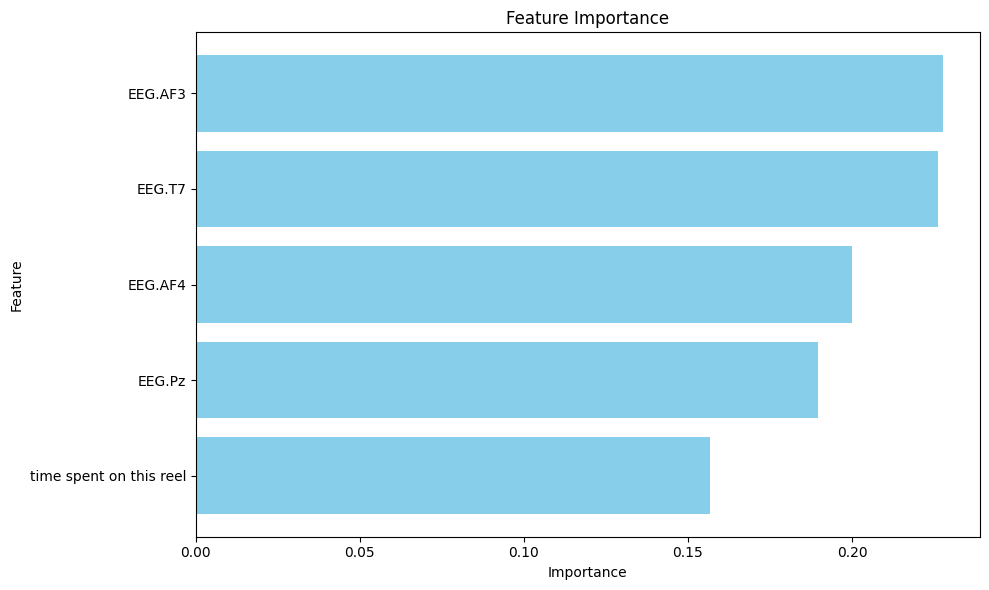

In [39]:
X_train, X_test, y_train, y_test, feature_names = preprocess_data(data)

# Train model
model = train_multi_class_model(X_train, y_train)

# Evaluate model
report, accuracy = evaluate_model(model, X_test, y_test)

# Print evaluation results
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Plot feature importance
plot_feature_importance(model, feature_names)


In [40]:
# save the model as a pth file
import joblib
# Save the trained model to a file
model_filename = 'random_forest_model.pkl'
joblib.dump(model, model_filename)


['random_forest_model.pkl']